In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import sympy as sp

from jitcode import y, t, jitcode

import sys
# Change path to your location of dynamicswitches
sys.path.append('/Users/luuk/OneDrive/Documents/School/machem2/pmcs/dynamicswitches')
import csutils as csu
import changingswitches as cs
from changingswitches import ResponseOneEnzymeXt

In [49]:
from abc import abstractmethod, abstractproperty

class ADyn():

    def __init__(self, **p):
        self.kappa = p['kappa']
        
    @abstractproperty
    def _xc(self):
        pass
        
    def _Fn(self, x):
        return np.tanh(self.kappa*(x-self._xc))

    def _F(self, x):
        return sp.tanh(self.kappa*(x-self._xc))


class XDyn(ResponseOneEnzymeXt):
    
    def __init__(self, **p):
        super().__init__(**p)

    def _f(self, x, a):
        return a + self.b * x ** self.n / (self.K ** self.n + x ** self.n)

    def _g(self, x):
        return self.ap + self.bp * self.Kp ** self.m / (self.Kp ** self.m + x ** self.m)


class Dynamics(XDyn, ADyn):

    def __init__(self, delta, epsilon, y0=[0,0,0], tf=20, **p):
        XDyn.__init__(self, **p)
        ADyn.__init__(self, **p)
        # jitcode.__init(self)
        self.setcontpars(0.01,2000)
        self.setstart(0,0,[0.1,0.1])
        self.compute_responsecurve()
        
        self.da = p['da']
        self.kX = p['kX']
        
        self.delta = delta
        self.epsilon = epsilon
        self.tf = tf
        self.y0 = y0
        self.sys = self._dynswitch
        
    @property
    def sys(self):
        return self._sys

    @sys.setter
    def sys(self, sys):
        self._sys = jitcode(sys)

    @property
    def _xc(self):
        return 0.5 * (self.folds[0][0] + self.folds[1][0])

    @property
    def _dynswitch(self):
        return [
            (self._f(y(0), y(2)) * (y(1) - y(0)) - self._g(y(0)) * y(0)) / self.epsilon,
            self.kX - y(1) * y(0),
            (self.a + self.da * self._F(y(1)) - y(2)) / self.delta
        ]
    
    def calc_traj(self):
        self._sys.set_initial_value(self.y0)
        self._sys.set_integrator('RK45')
        self.tv = np.arange(self._sys.t, self._sys.t + self.tf, 0.01)
        self.Xv, self.XTv, self.av = np.array([self._sys.integrate(t) for t in self.tv]).T

        


Generating, compiling, and loading C code.
generated C code for f


clang: warning: argument '-Ofast' is deprecated; use '-O3 -ffast-math' for the same behavior, or '-O3' to enable only conforming optimizations [-Wdeprecated-ofast]


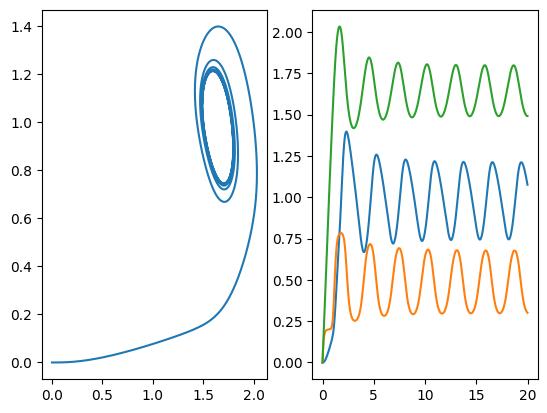

In [53]:
# p = dict(a=0.5, da=0.3, kX=1.6, kappa=5.0, b=1., K=1, n=5, ap=0.1, bp=1., Kp=1., m=5)

kwargs = {
    'a': 0.5,
    'da': 0.3,
    'kX': 1.6,
    'kappa': 5.0,
    'b': 1.0,
    'K': 1.0,
    'n': 5,
    'ap': 0.1,
    'bp': 1.0,
    'Kp': 1.0,
    'm': 5
}

dyn = Dynamics(delta=0.1, epsilon=0.5, **kwargs)
fig, axes = plt.subplots(1,2)


dyn.calc_traj()
dyn.delta = 0.01

axes[0].plot(XTv,Xv)
axes[1].plot(dyn.tv, dyn.Xv, label='$X$')
axes[1].plot(dyn.tv, dyn.av, label='$a$')
# axes[2].plot(tv[:-1], dav, label='$da$')
axes[1].plot(dyn.tv, dyn.XTv, label='$X_T$')

## Timescales

The functional form for $a$

$$\begin{align}
a(t) &= a(X_t) \\
&= \bar{a} + \Delta a \tanh \left(\kappa(X_t - X_c)\right)
\end{align}$$

This is simply some approximation. More generally, $a(t)$ is found from the ODE $\frac{da}{dt}=G(X, X_t, a)$

* The function $G$ is unknown, but we can force it's limiting case to coincide with $a(t)$ by $G(X, X_t, a) \overset{\text{def}}{=} \delta^{-1} \left(H(X_t) - a\right)$ such that when $\delta \rightarrow 0 \implies a(t) = H(X_t)$, i.e. $a$ changes instantenously according to $H(X_t)$ as was previously assumed

Generating, compiling, and loading C code.
generated C code for f


clang: warning: argument '-Ofast' is deprecated; use '-O3 -ffast-math' for the same behavior, or '-O3' to enable only conforming optimizations [-Wdeprecated-ofast]


Period 5.530000000000001


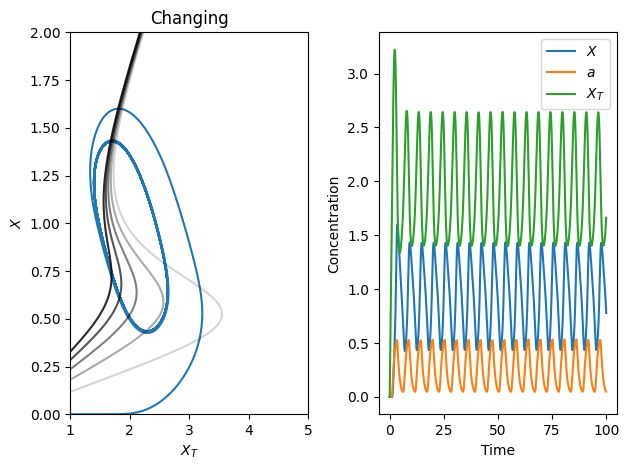

In [16]:
def f(x,a):
    return a +p['b']*x**p['n']/(p['K']**p['n'] + x**p['n'])
def g(x):
    return p['ap']+p['bp']*p['Kp']**p['m']/(p['Kp']**p['m'] + x**p['m'])

def F(x, xc):
    #function which returns values between -1 and 1
    return sp.tanh(kappa*(x-xc))
def Fn(x, xc):
    return np.tanh(kappa*(x-xc))

p = dict(b=1., K=1, n=5, ap=0.1, bp=1., Kp=1., m=5)
a = 0.3
da = 0.3

kX = 1.7
kappa = 5.0
epsilon = 1
delta = 1

# static switch a = 0.3
switch = cs.ResponseOneEnzymeXt(a=a, **p)
switchdat = []

switch.setcontpars(0.01,2000)
switch.setstart(0,0,[0.1,0.1])
switch.compute_responsecurve()

# threshold value used in a(X_T)
Xc = 0.5*(switch.folds[0][0] + switch.folds[1][0])

fig, axes = plt.subplots(1,2)

# simulate once for a static, once for a changing switch
# for i, da in enumerate([0, 0.3]):


dxdt = [
    1/epsilon * (f(y(0), y(2)) * (y(1) - y(0)) - g(y(0)) * y(0)),
    kX - y(1) * y(0),
    1/delta*(a + da * F(y(1), Xc) - y(2))
]

# jitcode takes a list of expressions for each dimensions: X and X_t in this case
y0 = [0,0,0] # initial condition X=X_t=0, a=0.1
odesys = jitcode(dxdt)
odesys.set_integrator('RK45')
odesys.set_initial_value(y0)

timeseries = []

tv = np.arange(odesys.t, odesys.t + 100, 0.01)
for time in tv: # integrate over time range
    timeseries.append( odesys.integrate(time) )

timeseries = np.array(timeseries)
Xv = timeseries[:,0]
XTv = timeseries[:,1]
av = timeseries[:,2]
dav = np.diff(av)

axes[0].plot(XTv,Xv)
axes[1].plot(tv, Xv, label='$X$')
axes[1].plot(tv, av, label='$a$')
# axes[2].plot(tv[:-1], dav, label='$da$')
axes[1].plot(tv, XTv, label='$X_T$')

# add labels etc
axes[0].set_xlabel('$X_T$')
axes[0].set_ylabel('$X$')
axes[0].set_xlim(1,5)
axes[0].set_ylim(0,2)

# period oscillation
# per, amp = csu.getperiodamplitude(tv, Xv)
# print('Period {}\nAmplitude {}'.format(per, amp))

ct = csu.getcrossingtimes_twothresholds(tv, Xv, switch.folds[1][1], switch.folds[0][1])
if len(ct)>3:
    per2 = abs(ct[-1][0]-ct[-3][0])
else:
    per2=0

print('Period {}'.format(per2))

# plot snapshots for the changing switch
# use a range of a values in between min and max a attained in the limit cycle
n=6
lowa = np.min(av[-500:])
higha = np.max(av[-500:])

for i, aa in enumerate(np.linspace(lowa, higha, n)):
    # mutate static switch object
    switch.a=aa
    switch.compute_responsecurve()
    axes[0].plot(switch.xtv, switch.xv, color='k', alpha=i/n)

axes[1].set_xlabel('Time')
axes[1].set_ylabel('Concentration')
axes[1].legend()

# axes[0].set_title('Static')
axes[0].set_title('Changing')
plt.tight_layout()
plt.show()

Generating, compiling, and loading C code.
generated C code for f


clang: warning: argument '-Ofast' is deprecated; use '-O3 -ffast-math' for the same behavior, or '-O3' to enable only conforming optimizations [-Wdeprecated-ofast]
MovieWriter ffmpeg unavailable; using Pillow instead.
/Users/luuk/OneDrive/Documents/School/machem2/pmcs/dynamicswitches/changingswitches.py:185: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  return fsolve(tosolve, [xt0,x0])
/Users/luuk/OneDrive/Documents/School/machem2/pmcs/dynamicswitches/changingswitches.py:185: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  return fsolve(tosolve, [xt0,x0])


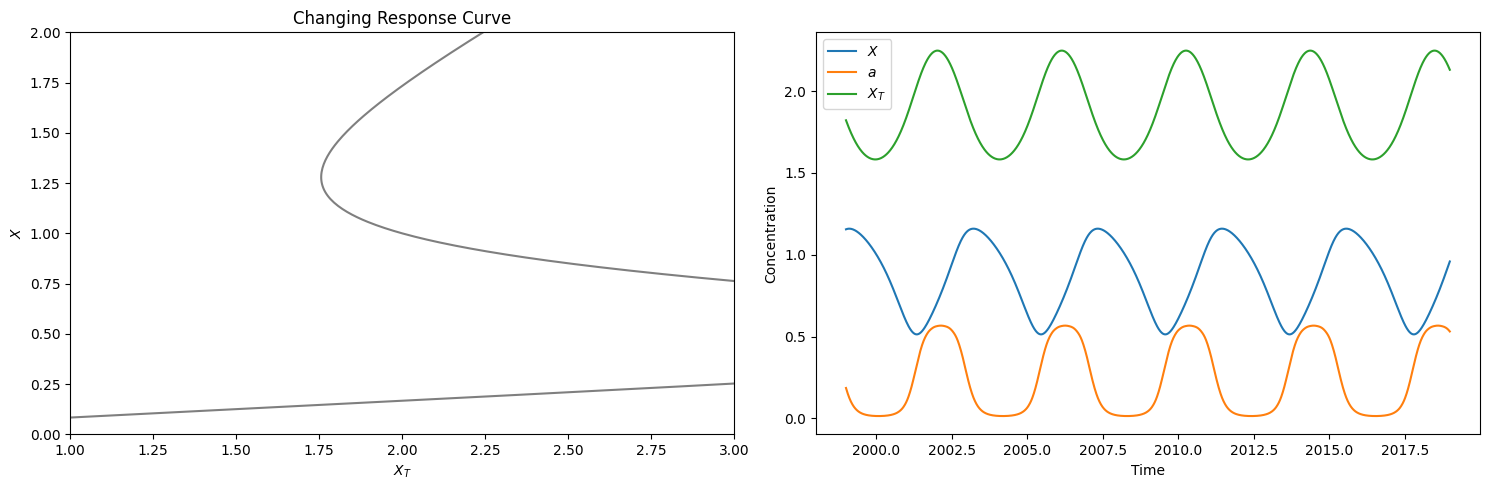

In [28]:
def f(x,a):
    return a +p['b']*x**p['n']/(p['K']**p['n'] + x**p['n'])
def g(x):
    return p['ap']+p['bp']*p['Kp']**p['m']/(p['Kp']**p['m'] + x**p['m'])

def F(x, xc):
    #function which returns values between -1 and 1
    return sp.tanh(kappa*(x-xc))
def Fn(x, xc):
    return np.tanh(kappa*(x-xc))
    

# Create figure and axes
fig, axes = plt.subplots(1, 2)

# Animation update function
def update(frame):
    axes[0].cla()  # Clear the current axes
    axes[1].cla()

    # Update the parameter a
    switch.a = frame * 0.1  # Change this to control the range of a
    switch.compute_responsecurve()

    # Plot the response curve
    axes[0].plot(switch.xtv, switch.xv, color='k', alpha=0.5)

    # Simulate the system
    timeseries = []
    tv = np.arange(odesys.t, odesys.t + 20, 0.01)
    for time in tv:  # Integrate over time range
        timeseries.append(odesys.integrate(time))

    timeseries = np.array(timeseries)
    Xv = timeseries[:, 0]
    XTv = timeseries[:, 1]
    av = timeseries[:, 2]
    # dav = np.diff(av)

    # Plot concentrations
    axes[1].plot(tv, Xv, label='$X$')
    axes[1].plot(tv, av, label='$a$')
    axes[1].plot(tv, XTv, label='$X_T$')

    # Set labels and titles
    axes[0].set_xlabel('$X_T$')
    axes[0].set_ylabel('$X$')
    axes[0].set_xlim(1, 3)
    axes[0].set_ylim(0, 2)
    axes[0].set_title('Changing Response Curve')

    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Concentration')
    axes[1].legend()

# Create animation
ani = FuncAnimation(fig, update, frames=np.linspace(0, 1, 100), repeat=True)
ani.save('dynswitch.gif')
plt.tight_layout()
plt.show()

In [ ]:
y0 = [0,0,0.3] # initial condition X=X_t=0, a=0.3
odesys = jitcode(dxdt)
odesys.set_integrator('RK45')
odesys.set_initial_value(y0)

timeseries = []

tv = np.arange(odesys.t, odesys.t + 20, 0.01)
for time in tv: # integrate over time range
    timeseries.append( odesys.integrate(time) )

timeseries = np.array(timeseries)
Xv = timeseries[:, 0]
XTv = timeseries[:, 1]
av = timeseries[:, 2]

ct = csu.getcrossingtimes_twothresholds(tv, Xv, switch.folds[1][1], switch.folds[0][1])
if len(ct)>3:
    per2 = abs(ct[-1][0]-ct[-3][0])
else:
    per2=0